# Sangkak AI Challenge: NER tasks

--------------------------------------------------------------------------

- **Author**: Elvis MBONING (NTeALan Research and Development Team)
- **Session**: février 2023

--------------------------------------------------------------------------

In this notebook, we try to implement new methods which can potentialy improved NER task in low african resource languages.

We propose a rule-based approach call **Position to position entity augmentation** to normalize and augment lowest training data for CRF model. Our work is based on this paper (Xiang Dai and Heike Adel, 2020)[https://aclanthology.org/2020.coling-main.343.pdf].

# Experiments

In this experiment, we want to build ML model based on Conditional Random Field (CRF). 

## 1- Data processing and analysis

### 1.1. Loading data from Masakhane folder


In [ ]:
# Install python packages dependencies
!pip3 install pandas python_crfsuite summarytools sklearn_crfsuite
!pip3 install iteration_utilities matplotlib

In [ ]:
# Download Masakhane dataset from Github
!git clone https://github.com/masakhane-io/masakhane-ner.git

In [1]:
from pathlib import Path
import pandas as pd
import joblib
from datetime import datetime

from auglib import read_format_iob_data

In [6]:
# Reading folder path
# Context Masahkane community
# Ramshaw and Marcus (1995) = IOB data format
language = 'bbj'
bbj_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/{language}')

dev_data_path   = bbj_ner_path / 'dev.txt'
train_data_path = bbj_ner_path / 'train.txt'

In [7]:
# read and extract iob data
extracted_train_data, pd_train_data, only_train_ner_data, o_train_ner_data = read_format_iob_data(train_data_path)
extracted_dev_data, pd_dev_data, only_dev_ner_data, o_dev_ner_data = read_format_iob_data(dev_data_path)

# some stats 
print("Total number of sentences in the train dataset: {:,}".format(pd_train_data["sentence_id"].nunique()))
print("Total words in the train dataset: {:,}".format(pd_train_data.shape[0]))
print("Total number of sentences in the dev dataset: {:,}".format(pd_dev_data["sentence_id"].nunique()))
print("Total words in the dev dataset: {:,}".format(pd_dev_data.shape[0]))

only_train_ner_data 

Total number of sentences in the train dataset: 3,384
Total words in the train dataset: 50,623
Total number of sentences in the dev dataset: 483
Total words in the dev dataset: 7,745


[[('Cameroon', 'B-ORG'),
  ('Tribune', 'I-ORG'),
  ('ntâmgǒ', 'B-DATE'),
  ('13', 'I-DATE'),
  ('fə̀fə̀', 'I-DATE'),
  ('2021', 'I-DATE'),
  ('.', 'O')],
 [('Ŋwâlâʼ', 'O'),
  ('nə̂ntʉɔ', 'O'),
  ('kə', 'O'),
  ('yó', 'O'),
  ('ŋké', 'O'),
  ('cúʼtə', 'O'),
  ('Yawude', 'B-LOC'),
  ('nə́', 'O'),
  ('gɔ́m', 'O'),
  ('páʼ', 'O'),
  ('pú', 'O'),
  ('wə́', 'O'),
  ('dóʼ', 'O'),
  ('gho', 'O'),
  ('lə', 'O'),
  ('.', 'O')],
 [('Ŋwâlâʼ', 'O'),
  ('nə̂ntʉɔ', 'O'),
  ('kə', 'O'),
  ('ŋwǎk', 'O'),
  ('dyə́', 'O'),
  ('gɔ́m', 'O'),
  ('páʼ', 'O'),
  ('gho', 'O'),
  ('lâʼlǎʼ', 'O'),
  ('wə́', 'O'),
  ('nə́', 'O'),
  ('bə́', 'O'),
  ('Kaməlûm', 'B-LOC'),
  ('lə', 'O'),
  ('.', 'O')],
 [('Ba', 'O'),
  ('mpáʼ', 'O'),
  ('ǎ', 'O'),
  ('ntʉ́m', 'O'),
  ('təŋláʼ', 'B-LOC'),
  ('kə́ŋshyə', 'I-LOC'),
  ('bə', 'O'),
  ('dəŋ', 'O'),
  ('msyap', 'O'),
  ('myə', 'O'),
  ('a', 'O'),
  ('ŋwak', 'O'),
  ('á', 'O'),
  ('cyə', 'O'),
  ('deŋ', 'O'),
  ('myə', 'O'),
  ('pú', 'O'),
  ('hə́ŋ', 'O')

In [22]:
# saving augmented data
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "train": extracted_train_data, 
    "pd_train": pd_train_data
}, f'preprocessing/{project}_train_data_{build_date}.joblib')

['preprocessing/sangkak-twi_train_data_2023-02-28_00:11:24.927403.joblib']

### 1.3. Analyzing data 

In [5]:
from matplotlib import pyplot as plt
import numpy as np

In [6]:
# quantification des tags/phrases dans le corpus d'entrainement
# credit: https://github.com/6chaoran/jupyter-summarytools
from summarytools import dfSummary, tabset

tabset({
    "train_data": dfSummary(pd_train_data).render(),
    "dev_data": dfSummary(pd_dev_data).render()
})

# Un controle visuel des données et ce tableau montre clairement qu'il y a 
# des problématiques de cohérence d'annotations avec l'usage du format IOB.

/tmp/ipykernel_15483/1678084774.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "train_data": dfSummary(pd_train_data).render(),
/tmp/ipykernel_15483/1678084774.py:7: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "dev_data": dfSummary(pd_dev_data).render()


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,sentence_id[int64],Mean (sd) : 2308.2 (1325.1)min < med < max:1.0 < 2315.0 < 4532.0IQR (CV) : 2300.0 (1.7),"4,532 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiklEQVR4nO3aPY7aQByG8f+EDxlQjBAr6LhApBSUNLlBDps2XZCWC3ADGoSE+BBkLYxxiijlLtisl3knz69lZ22NH814EC7PcwN89+nRNwDcov7oG0A4nHMtM2uWHH7K8/zltQ8JFe/COdfq9/vf4zjulRm/3+83zrkfr8VKqHgvzTiOe5PJ5KXb7SZFBu52u+j5+bm3Xq+bZkaoqF63200Gg8HvEkNbb33IYQoSCBUSvN76qzxFhirUOfM21KpPkSEKec68DdUqPkUGKtg58zlUM6vuFHmN8hb6qDmrkvehPkLIW6iqq6Eqryx3uGsLnU6ng/V6/eSc25e4tuqcVerNUP/3laXMFno8Hhtpmn4djUa1Wq1WKHIzs+12e3DO/TSzwmPNLL5cLo0S47x3bUUN9uW8KqfTqR5FUXs8HifD4XBTZOxyufw8m82+jUajpzKRp2kaZVn2JUmSX2ZW5h3VWze9o5Z9Oc+yLDaz2DlX+MZMfHXodDqF52yz2bTKRm5mtlgsevP5vH0+n2tFx5qZZVnWME+fV2WHqXu3wJBXh2vKRG72N/Sy1/T9eVUW6j1boFnYq4OPHv28rqn86ylWBy2PeF63CPJ7VN9XBxQXZKj/+Lo6oDh+5gcJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJ9Vv+aLfbRUX/8eFwiMzMjsdjtFqt2h85XvXaqvd97/hb+voD+32p3/4ezlEAAAAASUVORK5CYII="">",0(0.0%)
2,word[object],"1. .2. n3. -4. ,5. sẽn6. a7. b8. ne9. la10. tɩ11. other","8,860 (6.9%)5,882 (4.6%)4,850 (3.8%)4,320 (3.4%)4,141 (3.2%)3,000 (2.3%)2,883 (2.2%)2,620 (2.0%)2,568 (2.0%)2,132 (1.7%)87,155 (67.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEJElEQVR4nO3dQWobWQBF0a8gTDKRMAYtRovoxfYitBtjpEEcMlEPkjSxLclOU3XjqM+ZBTQQ5PJFFf8li+PxOKDw4Xd/Af4/xEZGbGTERkZsZMRGRmxkxEZGbGQWY4xPY4ybN37+6/F4fJzx+3DFlnd3d3+tVqvbt3z4cDg8LBaLvwXHf7FcrVa32+32cb1ef7n0wf1+/3G3293e39/fjDHExi9bjjHGer3+stlsPr/h859m/j5cMQ8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGZjnGt7tqr33wLZ+BS5aHw+Fht9vdjjfcVTscDg9jjK/zfy2ukQ0CmYV/MovKayebk4zJXFxXWVMxpbPrKmsqpvbausqaisl4qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbm7ODFwIWpXRy8GLgwJdfCyRi8kLl0sjnVmNTZwYuxC1M7OXgxdmEOlwYvxi5MyktdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MicHL8YuzOHs4MXYham5Fk7G4IWMBwQy535G/YQyuZPrKssq5vBiXWVZxVzOrassq5icBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyL9ZVllXM5eS6yrKKObgWTsa6ioyTjYzBCxmDFzIGL2S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMa+FkDF7InDrZnGrM4sXgxdiFuTwZvBi7MKdTgxdjF2bhpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZF5sq6yrGJOL9ZVllXMxQaBjHUVmecnm1ON2TxZV1lWMacPP9ZV2+328Xt0z9fxMIl/11Xf/2xZxWy81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiPz4r8Tgrn8PHgxdmFWroWTMXgh42QjY/BCxuCFjMELGS91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNaOBmDFzIeEMj4GSVjXUXGuoqMdRUZDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcS2cjHUVGScbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJB5frLxPl3FL86TwQvv07UMkZY/Bi8/7RB4R/b7/cfdbnd7f39/M8b4s2Mb49vgZbPZfP7dX4azrmKI5KUuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYOXd+6a/m5+HrxcxTWWa3QtQyTXwv8MV3Et3OCFjAcEMmIjIzYyYiMjNjJiIyM2MmIjIzYy/wAC8x1m9iXLnAAAAABJRU5ErkJggg=="">",0(0.0%)
3,iob_tag[object],1. O2. I-DATE3. B-LOC4. I-ORG5. I-PER6. B-PER7. B-ORG8. B-DATE9. I-LOC,"117,393 (91.4%)4,001 (3.1%)1,540 (1.2%)1,182 (0.9%)1,071 (0.8%)925 (0.7%)890 (0.7%)795 (0.6%)614 (0.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADS0lEQVR4nO3cQWpbVwCG0Ssh0mryhBB4GV6AF5HFdhFagPdhjN+gSjNRB01LIQmuRN8nopwzF7zBx5X1uL9X5/N5QGF96wfg5yE2MmIjIzYyYiMjNjJiI7MaY2zHGB9u/SD8cD6fz+fTJR/YHA6Hj9M07Zd6Iu7TPM+vq9Xqt0uC20zTtH96ejrtdrtPSz4c9+Pt7e3X4/G4f3l5+TDG+O+xjTHGbrf79PDw8PtiT8c92l76AT8QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyGzG+OvKyK0fhB/Htb1s5nl+PR6P+3HFlRF+XvM8v44xPl/yGdfCudbF18JX/tcHle+dbBdXC+/55uDlmjEDvOerwcu1YwZ4z/cGL36Z8r/zUpeM2MiIjYzYyIiNjNjIiI2M2M

<AxesSubplot: >

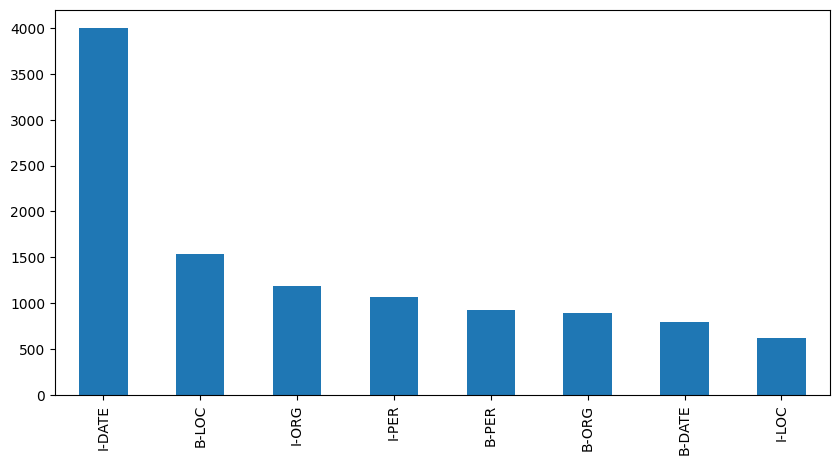

In [7]:
# representation of each entity tag
pd_train_data[pd_train_data.iob_tag != 'O']["iob_tag"]\
.value_counts().plot(kind="bar", figsize=(10,5))

# On remarque ici que le tag date représente 40% des tags (en position I ou B)

La phrase la plus longue contient 77 mots.
ID de la plus longue phrase 369.

La phrase la plus longue du corpus est:
 """" Ntentan ɛkwan a wɔfrɛ no Ƹntakyenegye no , Dɔla no Ɔpepem Edu Kosi Ɔpepem Aduonum - Enum . ( $ 10 , 000 , 000 - $ 55 , 000 , 000 ) , kilomita biara , ɛna Asefate nsiesie nso boɔ yɛ Dɔla Ɔpepem Baako akyire ɛpɔ mmienu kosi Ɔpepem Baako akyire ɛpɔ ɛnan . ( $ 1 , 200 , 000 - 1 , 400 , 000 ) , kilomita baako biara . .


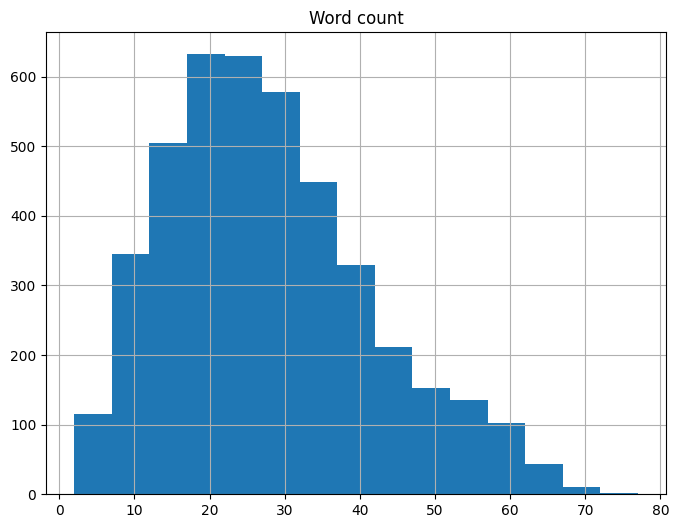

In [23]:

word_counts = pd_train_data.groupby("sentence_id")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=15, figsize=(8,6))

# On constate que le nombre de mots moyens par phrase est de 15
MAX_LENGTH_SENTENCE = word_counts.max()[0]
print("La phrase la plus longue contient {} mots.".format(MAX_LENGTH_SENTENCE))
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_LENGTH_SENTENCE].index[0]
print("ID de la plus longue phrase {}.".format(longest_sentence_id))
longest_sentence = pd_train_data[pd_train_data["sentence_id"]==longest_sentence_id]["word"].str.cat(sep=' ')
print(f"\nLa phrase la plus longue du corpus est:\n {longest_sentence}")


In [24]:
all_words = list(set(pd_train_data["word"].values))
all_tags = list(set(pd_train_data["iob_tag"].values))

print("Nombre de mots uniques: {}".format(pd_train_data["word"].nunique()))
print("Nombre de tags uniques : {}".format(pd_train_data["iob_tag"].nunique()))

Nombre de mots uniques: 11610
Nombre de tags uniques : 9


## 2- Features engineering

We will use differents kind of features to modelize our model. As ghomala is an african language, it is important to consider some of its features.

Any Bantu or semi-Bantu language use tone markers as morpho-syntatic properties to differentiate word or meaning. 

In [10]:
import unidecode
import re
from datetime import datetime
import string
import math
import unicodedata

### 2.1. Features based on african linguistics specificities

In [11]:
# importing features module 
from features import remove_accents, number_tone_word, extract_tone


In [25]:
# Constructing word features based on tones and API charaters
words_caracters = set([y.lower() for x in all_words for y in x])
all_caracters   = string.punctuation+string.ascii_letters+string.digits+''
tone_caracters  = list(set([x for x in words_caracters if x not in all_caracters]))
cpm_search      = re.compile(str(tone_caracters))

# Set of functions that normalizes and get features from datasets
bantou_tones = [f"{x} " for x in " ́̄̀̌̂" if x != " "]
string_tones = "".join(bantou_tones)
tones_search = re.compile(string_tones)

bantou_letters = string.ascii_letters+"ǝɔᵾɓɨşœɑʉɛɗŋøẅëïə"

non_tone = remove_accents("fə̀fə̀")

print(
    len("fə̀fə̀"), 
    len(non_tone), 
    number_tone_word("fə̀fə̀"), 
    "---"+extract_tone("fə̀fə̀")
)

print([x for x in "ntâmgǒ"])
print(tone_caracters, string_tones)

print(tone_caracters)

6 2 2 ---̀ ̀
['n', 't', 'â', 'm', 'g', 'ǒ']
['€', 'ò', 'ô', 'ĩ', 'ɑ', 'ã', 'ɛ', 'ɔ', '¢', 'ẽ', '£', 'ȼ', '́', 'ú', 'á', 'ƹ', 'ũ', 'õ'] ́ ̄ ̀ ̌ ̂ 
['€', 'ò', 'ô', 'ĩ', 'ɑ', 'ã', 'ɛ', 'ɔ', '¢', 'ẽ', '£', 'ȼ', '́', 'ú', 'á', 'ƹ', 'ũ', 'õ']


### 2.2. Features based on word and its contexts

In [13]:
# l'ajout des tags suivants au mot courant améliore signficativement le modèle
# l'ajout des informations sur les tons

from features import sent2features, sent2labels


### 2.3. Building all features and apply them to all datasets


In [26]:
# Build features from dataset 
print(len(extracted_train_data))

#train_sents = format_data(pd_train_data)
#dev_sents = format_data(pd_dev_data)
train_sents = [[word for word in sentence] for sentence in extracted_train_data]
dev_sents = [[word for word in sentence] for sentence in extracted_dev_data]

Xtrain = [sent2features(s) for s in train_sents]
ytrain = [sent2labels(s) for s in train_sents]

Xdev = [sent2features(s) for s in dev_sents]
ydev = [sent2labels(s) for s in dev_sents]


print(f"Train X aug lenght: {len(Xtrain)} | {len(ytrain)}")
print(f"Dev X aug lenght: {len(Xdev)} | {len(ydev)}")
Xtrain[2]

4240
Train X aug lenght: 4240 | 4240
Dev X aug lenght: 605 | 605


[{'bias': 1.0,
  'word': 'Nsu',
  'word.tones': '',
  'word.normalized': 'Nsu',
  'word.position': 0,
  'word.has_hyphen': False,
  'word.lower()': 'nsu',
  'word.start_with_capital': True,
  'word.have_tone': False,
  'word.ispunctuation': False,
  'word.isdigit()': False,
  'BOS': True,
  '+1:word': 'a',
  '+1:word.position': 1,
  '+1:word.letters': 'a',
  '+1:word.normalized': 'a',
  '+1:word.start_with_capital': False,
  '+1:len(word2)': 1,
  '+1:word.lower()': 'a',
  '+1:word.isdigit()': False,
  '+1:word.ispunctuation': False},
 {'bias': 1.0,
  'word': 'a',
  'word.tones': '',
  'word.normalized': 'a',
  'word.position': 1,
  'word.has_hyphen': False,
  'word.lower()': 'a',
  'word.start_with_capital': False,
  'word.have_tone': False,
  'word.ispunctuation': False,
  'word.isdigit()': False,
  '-1:word': 'Nsu',
  '-1:word.position': 0,
  '-1:word.letters': 'N s u',
  '-1:word.normalized': 'Nsu',
  '-1:word.start_with_capital': True,
  '-1:len(word1)': 3,
  '-1:word.lower()': 'ns

In [27]:
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "Xtrain": Xtrain, "ytrain": ytrain, 
    "Xdev": Xdev, "ydev": ydev
}, f'preprocessing/{project}_featurised_train_dev_data_{build_date}.joblib') 

['preprocessing/sangkak-twi_featurised_train_dev_data_2023-02-28_00:12:04.782500.joblib']

# 3. Modelling with CRF algorithm

In [16]:
#import pycrfsuite
import sklearn_crfsuite
import math, string, re
import scipy
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite import metrics
from collections import Counter


### 3.1. Initialisation of pycrfsuite with training data

In [29]:
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')
model_name = Path(f"models/no_aug/crf_{project}_{build_date}.model")
model_file = str(model_name)
file_crf = Path(f"models/no_aug/crf_{project}_{build_date}.object")

params = {
    "algorithm": 'lbfgs',
    "c1": 0.0920512484757745,
    "c2": 0.0328771171605105, 
    "max_iterations":150,
    "verbose":True,
    "num_memories":10000,
    "epsilon": 1e-3,
    "linesearch": "MoreThuente",
    "max_linesearch":100000,
    "delta":1e-4,
    #n_job=-1,
    #"c": 2,
    #"pa_type": 2,
    "all_possible_states":True,
    "all_possible_transitions":True, 
    "model_filename": model_file
}

crf = sklearn_crfsuite.CRF(**params)

crf.fit(Xtrain, ytrain, Xdev, ydev)    

final = {"crf": crf, "params": params}
joblib.dump(final, file_crf) 


loading training data to CRFsuite: 100%|██████████| 4240/4240 [00:03<00:00, 1370.29it/s]


loading dev data to CRFsuite: 100%|██████████| 605/605 [00:00<00:00, 1300.79it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 1
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1101942
Seconds required: 6.405

L-BFGS optimization
c1: 0.092051
c2: 0.032877
num_memories: 10000
max_iterations: 150
epsilon: 0.001000
stop: 10
delta: 0.000100
linesearch: MoreThuente
linesearch.max_iterations: 100000

Iter 1   time=2.00  loss=203661.00 active=1101684 precision=0.105  recall=0.111  F1=0.108  Acc(item/seq)=0.949 0.653  feature_norm=1.00
Iter 2   time=0.30  loss=192164.60 active=594299 precision=0.105  recall=0.111  F1=0.108  Acc(item/seq)=0.949 0.653  feature_norm=0.94
Iter 3   time=0.29  loss=136961.64 active=224602 precision=0.105  recall=0.111  F1=0.108  Acc(item/seq)=0.949 0.653  feature_norm=1.04
Iter 4   time=0.71  loss=98845.34 active=538833 precision=0.105  recall=0.111  F1=0.108  Acc(item/seq)=0.949 0.653  feature_norm=1.11
Iter 5   time=0.33  loss=90548.

['models/no_aug/crf_sangkak-twi_2023-02-28_00:15:23.342249.object']

# 4- Grid search

In other to optimised parameters of CRF model, we want here to find the best parameters that will fit to our data.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

In [28]:
# get initial model parameters and delete c1 and c2 parameters
del params['c1']
del params['c2']

crf_grill = sklearn_crfsuite.CRF(**params)

labels = list(crf.classes_)
labels.remove('O')

params_space = {
    'c1': scipy.stats.expon(scale=0.1),
    'c2': scipy.stats.expon(scale=0.05)
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf_grill, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=5,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [24]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0920512484757745, 'c2': 0.0328771171605105}
best CV score: 0.7372461091914264
model size: 2.10M


Dark blue => 0.334, dark red => 0.7347


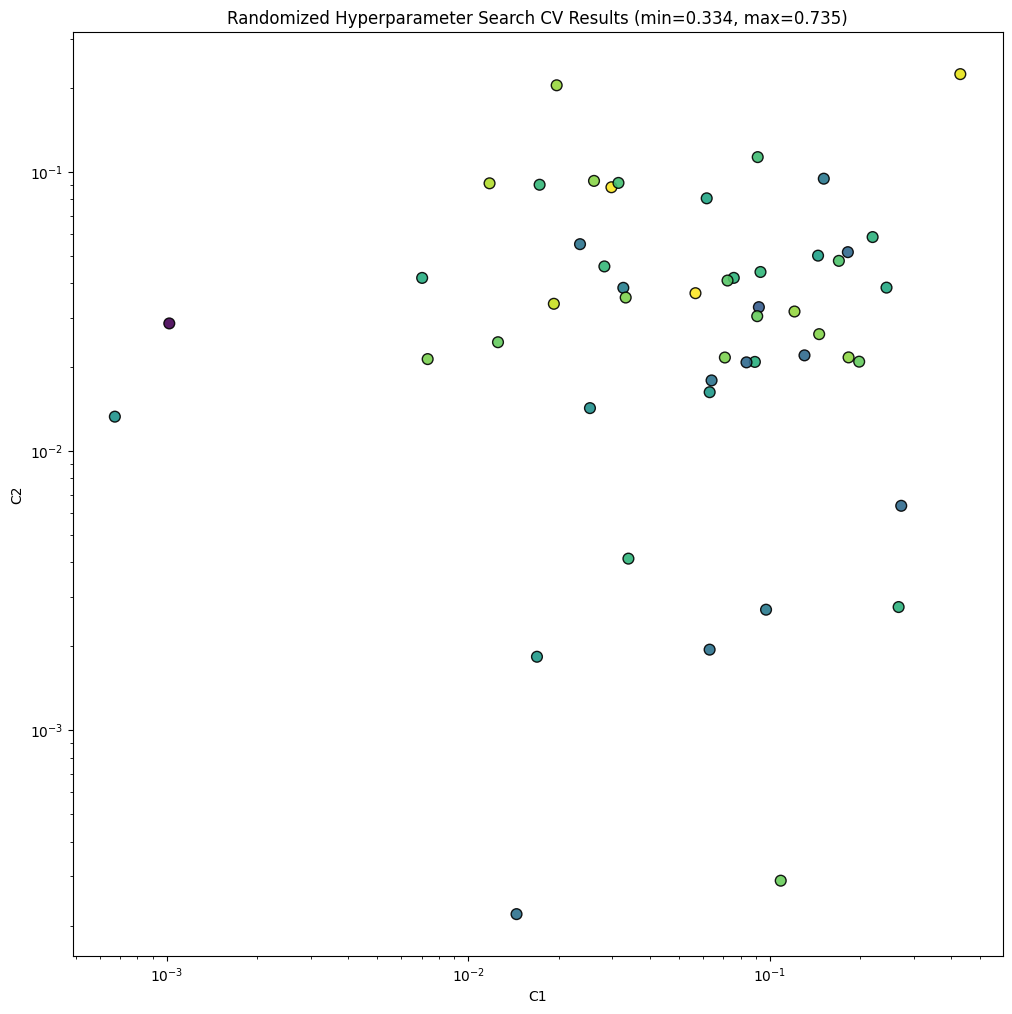

In [33]:
#print(rs.cv_results_)
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_score_time']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [35]:
crf_grid = rs.best_estimator_
y_pred = crf_grid.predict(Xtest)
print(metrics.flat_classification_report(
    ytest, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

      B-DATE      0.733     0.611     0.667       180
      I-DATE      0.885     0.893     0.889       345
       B-LOC      0.706     0.684     0.694       256
       I-LOC      0.176     0.200     0.188        30
       B-ORG      0.687     0.475     0.561       217
       I-ORG      0.220     0.344     0.268        90
       B-PER      0.819     0.647     0.723       399
       I-PER      0.850     0.855     0.852       385

   micro avg      0.745     0.694     0.718      1902
   macro avg      0.635     0.588     0.605      1902
weighted avg      0.760     0.694     0.722      1902



In [36]:

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-LOC  -> I-LOC   3.344981
I-ORG  -> I-ORG   2.632436
B-DATE -> I-DATE  2.550764
B-ORG  -> I-ORG   2.534023
B-LOC  -> I-LOC   2.359503
B-PER  -> I-PER   2.310736
I-DATE -> I-DATE  2.271082
O      -> O       1.607063
I-DATE -> B-LOC   0.682219
I-PER  -> I-PER   0.679676
O      -> B-LOC   0.167310
O      -> B-DATE  0.159324
O      -> B-ORG   0.067802
O      -> B-PER   0.047198
I-PER  -> O       0.033732
B-ORG  -> B-DATE  0.007491
I-PER  -> B-DATE  0.002353
I-DATE -> B-ORG   0.000213
B-LOC  -> B-DATE  -0.000526
I-ORG  -> B-LOC   -0.190175

Top unlikely transitions:
I-LOC  -> B-LOC   -2.663649
B-LOC  -> B-LOC   -2.817735
B-ORG  -> I-DATE  -2.964340
I-PER  -> B-PER   -2.986770
B-DATE -> B-DATE  -3.008049
I-ORG  -> I-PER   -3.124413
B-PER  -> B-PER   -3.141215
I-DATE -> I-ORG   -3.247324
B-PER  -> I-ORG   -3.349716
I-DATE -> B-DATE  -3.379048
B-LOC  -> I-ORG   -3.480373
I-ORG  -> I-DATE  -3.488083
I-PER  -> I-ORG   -3.606551
B-ORG  -> I-PER   -3.624743
B-LOC  -> I-DAT

In [37]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
4.137301 O        BOS
3.553198 O        word.ispunctuation
3.275343 B-DATE   word[-2:]:dɛ
3.266737 B-DATE   word[:2]:20
3.235340 O        word.unaccent:l
3.181338 B-ORG    word[-2:]:eb
3.141069 B-ORG    word[-2:]:̂t
3.013767 O        word.unaccent:b
2.944115 O        word.unaccent:e
2.931817 B-ORG    word[-2:]:AC
2.904804 O        word[-2:]:tə
2.867400 B-ORG    word[-3:]:tel
2.750992 B-ORG    word[:3]:dyə
2.739059 O        word.unaccent:N
2.731705 O        word[-2:]:ɔm
2.731415 B-PER    word[-2:]:à
2.714894 B-DATE   word.unaccent:cwl
2.656152 O        word.unaccent:pu
2.647035 B-LOC    word.lower():noso
2.619886 I-DATE   word.isdigit()
2.552714 O        word.unaccent:G
2.507317 B-ORG    word[:2]:dy
2.449433 B-PER    word[-3:]:ufa
2.407621 O        word.unaccent:A
2.401207 B-DATE   word[-3:]:zʉ́
2.390363 B-LOC    word[-3:]:ala
2.351410 O        word[-2:]:əŋ
2.302675 O        word[-2:]:ʉɔ
2.300447 O        word[:2]:pu
2.298171 B-DATE   word.lower():daʼdaʼ

Top negative:
-1